Using device: cuda


>>> Handling LSTM Model <<<

[INFO] Found existing extended_prediction_best_model_LSTM.pt. Loading without re-training...
LSTM -> Test Loss (Huber): 46.553429
LSTM -> Test MAPE:        3.17%
LSTM -> Test Accuracy:    96.83%
LSTM -> Test MSE:         2554.752257


>>> Handling GRU Model <<<

[INFO] Found existing extended_prediction_best_model_GRU.pt. Loading without re-training...
GRU -> Test Loss (Huber): 32.922932
GRU -> Test MAPE:        2.24%
GRU -> Test Accuracy:    97.76%
GRU -> Test MSE:         1463.354985


>>> Handling RNN Model <<<

[INFO] Found existing extended_prediction_best_model_RNN.pt. Loading without re-training...
RNN -> Test Loss (Huber): 15.907505
RNN -> Test MAPE:        1.10%
RNN -> Test Accuracy:    98.90%
RNN -> Test MSE:         390.384645


>>> Handling CNN Model <<<

[INFO] Found existing extended_prediction_best_model_CNN.pt. Loading without re-training...
CNN -> Test Loss (Huber): 55.302361
CNN -> Test MAPE:        3.76%
CNN -> Test A

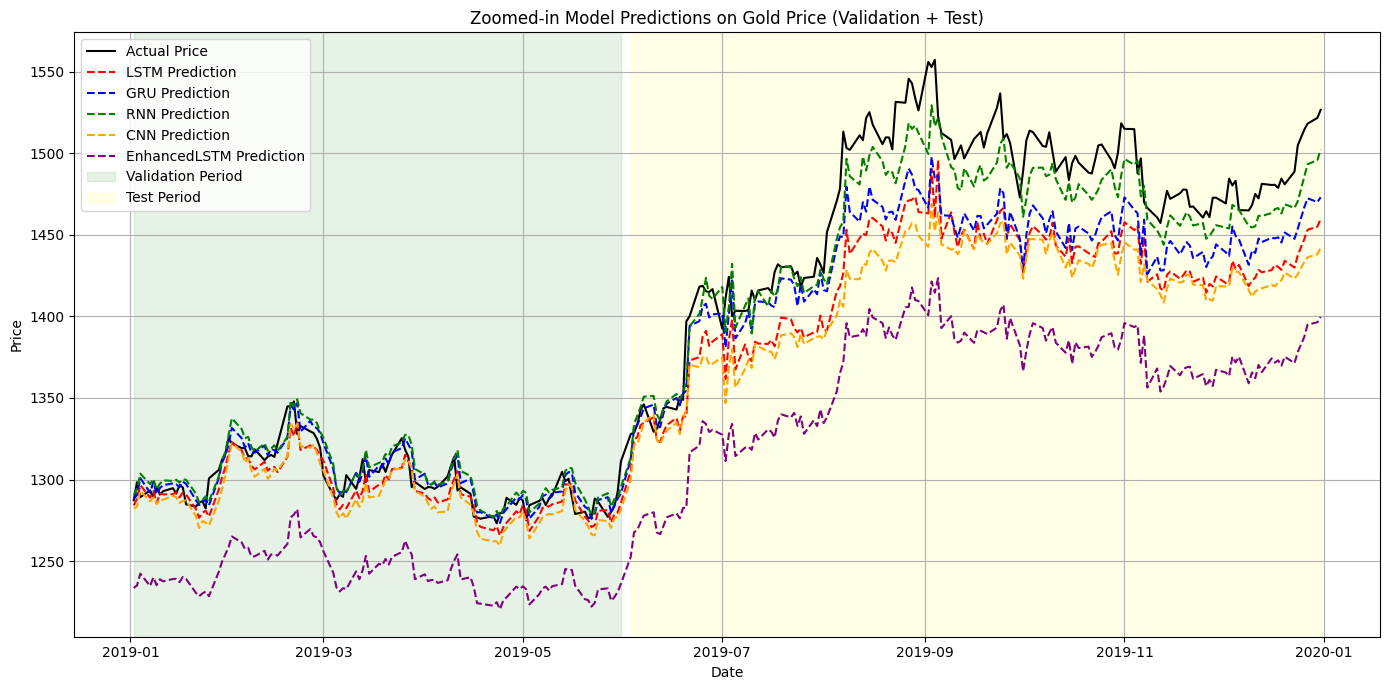


================ NO VALIDATION (Piecewise) ================
--- NO VAL: Conservative Strategy ---
Total trades: 5
Final P&L: 428.90 (in gold price units)
Holding: 150 long days, 87 short days, 21 flat days

--- NO VAL: Optimistic Strategy ---
Total trades: 5
Final P&L: 443.40 (in gold price units)
Holding: 171 long days, 87 short days, 0 flat days



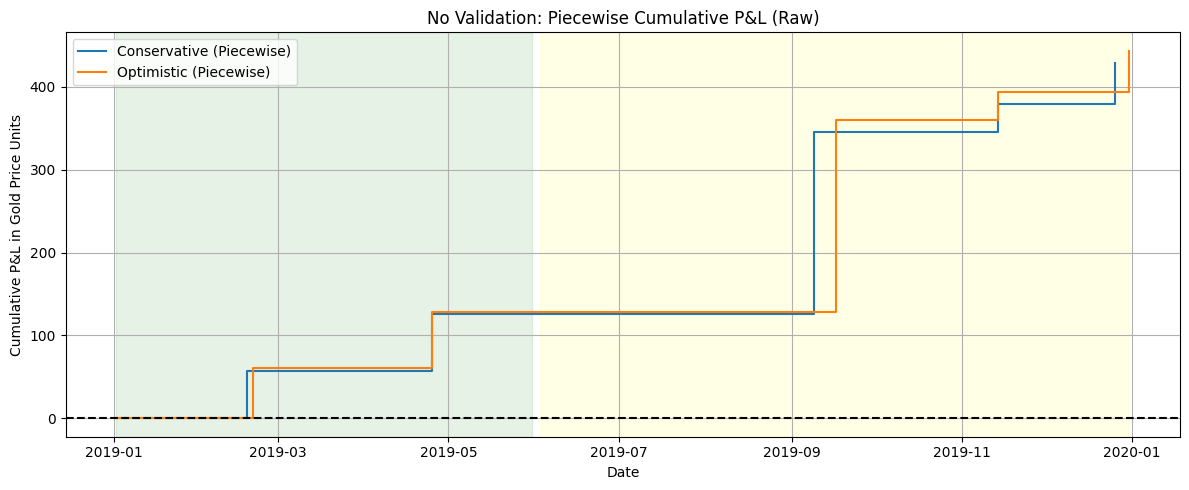

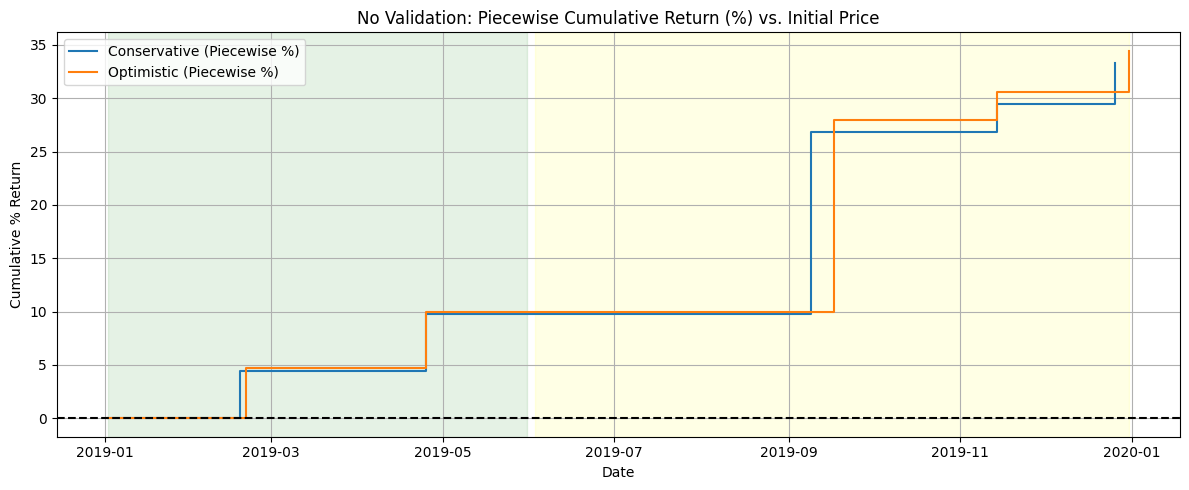


================ ONE-QUARTER VALIDATION (Piecewise) ================
--- 1/4 VAL: Conservative Strategy ---
Total trades: 5
Final P&L: 429.70
Holding: 151 long days, 88 short days, 19 flat days

--- 1/4 VAL: Optimistic Strategy ---
Total trades: 5
Final P&L: 437.20
Holding: 170 long days, 88 short days, 0 flat days



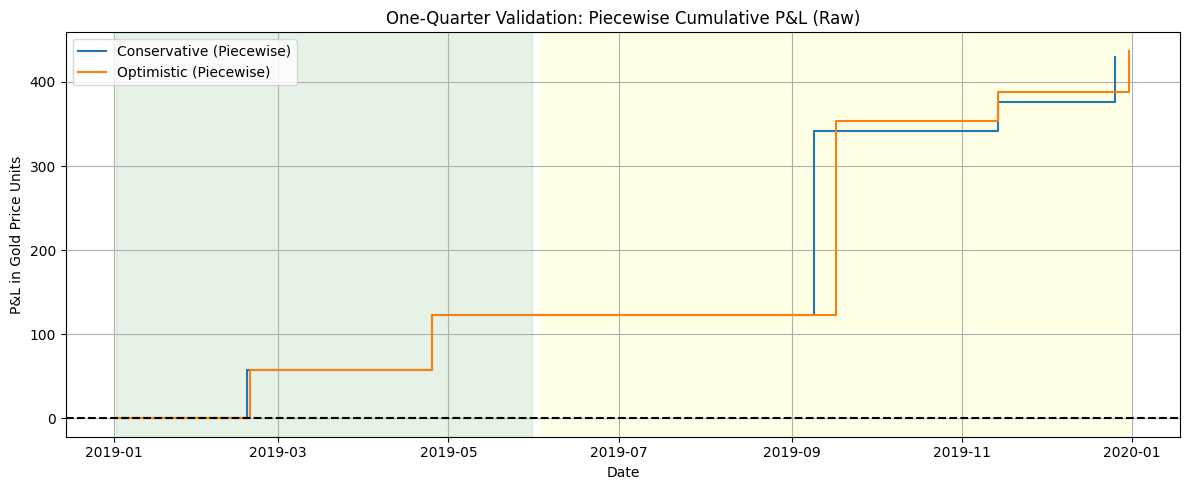

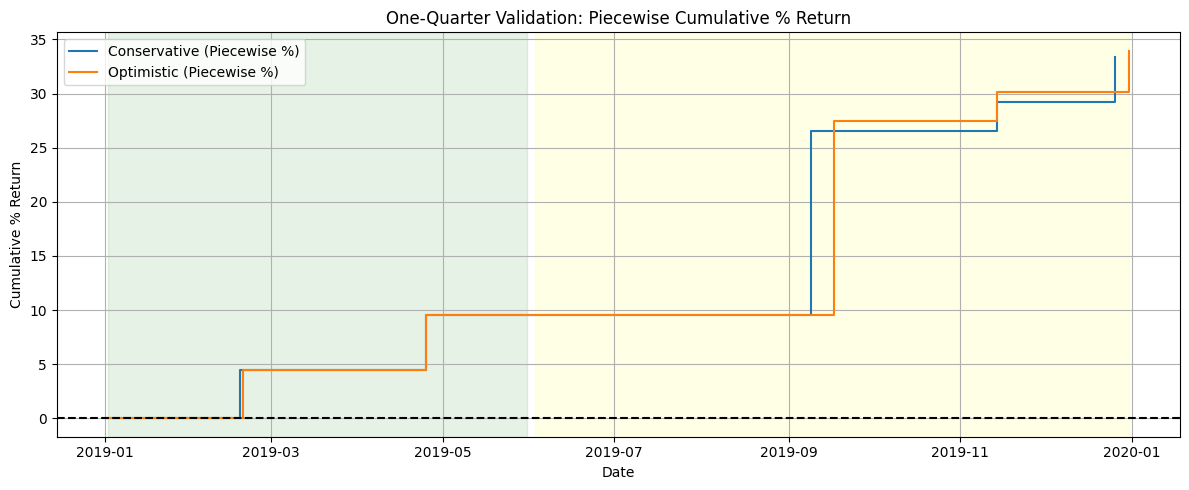


================ HALF VALIDATION (Piecewise) ================
--- 1/2 VAL: Conservative Strategy ---
Total trades: 5
Final P&L: 400.10
Holding: 148 long days, 88 short days, 22 flat days

--- 1/2 VAL: Optimistic Strategy ---
Total trades: 5
Final P&L: 437.20
Holding: 170 long days, 88 short days, 0 flat days



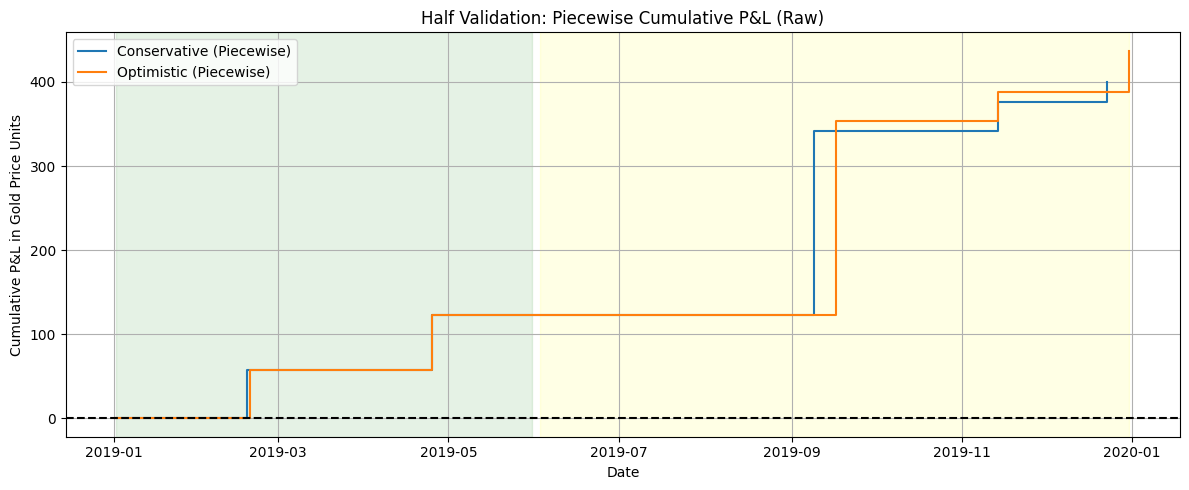

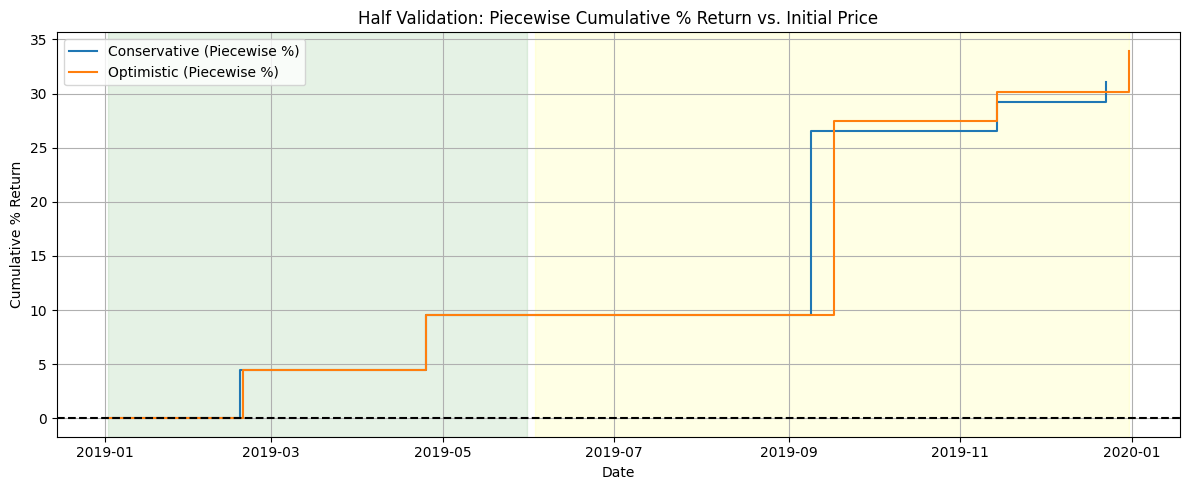


================ FINAL MERGED DIAGRAM (All 6 lines) ================



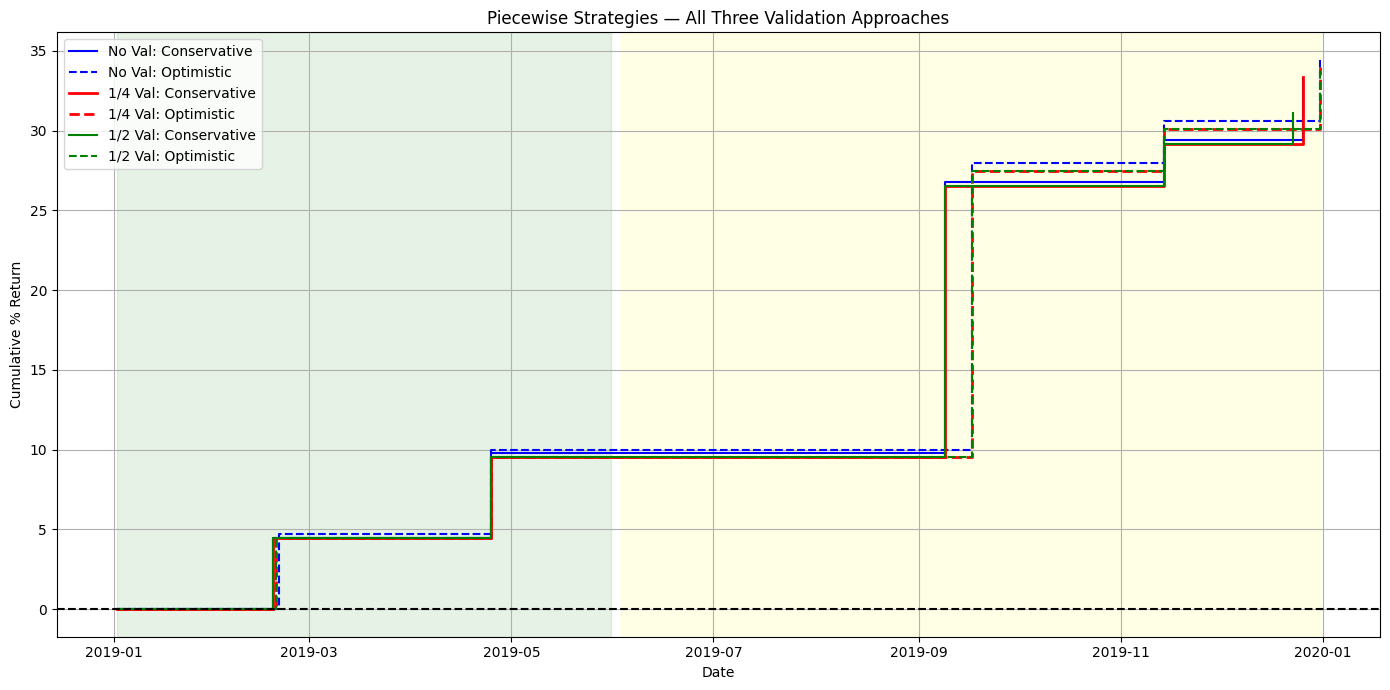

Done! All three approaches (No Val, 1/4 Val, 1/2 Val) are fully plotted.


In [1]:
##############################################################################
# 1) Imports and Setup
##############################################################################
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    mean_absolute_percentage_error, 
    mean_squared_error, 
    r2_score
)
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import os
import random
import warnings
import matplotlib.dates as mdates

warnings.filterwarnings("ignore")  # Hide any warnings for cleaner output

# Set random seeds
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)


##############################################################################
# 2) Load and Prepare Data
##############################################################################
df = pd.read_csv('Gold Price_Year 2017-2019.csv')
df.drop(['Vol.', 'Change %'], axis=1, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

num_cols = df.columns.drop(['Date'])
df[num_cols] = df[num_cols].replace({',': ''}, regex=True)
df[num_cols] = df[num_cols].astype('float64')

assert df.duplicated().sum() == 0, "Duplicate rows found!"
assert df.isnull().sum().sum() == 0, "Missing values found!"

features = ['Price', 'Open', 'High', 'Low']
data = df[features].values

# Scale data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Create sequences
window_width = 30
X, y, dates = [], [], []
for i in range(window_width, len(data_scaled)):
    X.append(data_scaled[i - window_width : i])
    y.append(data_scaled[i, 0])  # Price as target
    dates.append(df['Date'].iloc[i])

X = np.array(X)
y = np.array(y)
dates = np.array(dates)

# Train/Val/Test masks
train_mask = (
    (dates >= pd.to_datetime('2017-01-03')) &
    (dates <= pd.to_datetime('2018-12-31'))
)
val_mask = (
    (dates >= pd.to_datetime('2019-01-02')) &
    (dates <= pd.to_datetime('2019-05-31'))
)
test_mask = (
    (dates >= pd.to_datetime('2019-06-03')) &
    (dates <= pd.to_datetime('2019-12-31'))
)

X_train, y_train = X[train_mask], y[train_mask]
X_val, y_val = X[val_mask], y[val_mask]
X_test, y_test = X[test_mask], y[test_mask]

train_dates = dates[train_mask]
val_dates = dates[val_mask]
test_dates = dates[test_mask]

# Convert to tensors
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float().unsqueeze(1)
X_val_tensor = torch.from_numpy(X_val).float()
y_val_tensor = torch.from_numpy(y_val).float().unsqueeze(1)
X_test_tensor = torch.from_numpy(X_test).float()
y_test_tensor = torch.from_numpy(y_test).float().unsqueeze(1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


##############################################################################
# 3) Define Model
##############################################################################
class BaseModel(nn.Module):
    def __init__(self, model_type='LSTM', hidden_size=128, num_layers=2, dropout=0.1, lr=0.0005):
        super(BaseModel, self).__init__()
        self.model_type = model_type
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = dropout
        self.lr = lr
        
        if model_type == 'LSTM':
            self.rnn = nn.LSTM(
                input_size=len(features),
                hidden_size=hidden_size,
                num_layers=num_layers,
                batch_first=True,
                dropout=dropout,
            )
            self.fc = nn.Linear(hidden_size, 1)

        elif model_type == 'GRU':
            self.rnn = nn.GRU(
                input_size=len(features),
                hidden_size=hidden_size,
                num_layers=num_layers,
                batch_first=True,
                dropout=dropout,
            )
            self.fc = nn.Linear(hidden_size, 1)

        elif model_type == 'RNN':
            self.rnn = nn.RNN(
                input_size=len(features),
                hidden_size=hidden_size,
                num_layers=num_layers,
                batch_first=True,
                nonlinearity='relu',
                dropout=dropout,
            )
            self.fc = nn.Linear(hidden_size, 1)

        elif model_type == 'CNN':
            self.conv1 = nn.Conv1d(in_channels=len(features), out_channels=64, kernel_size=3)
            self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3)
            conv_output_length = window_width - 2 * (3 - 1)
            self.fc = nn.Linear(128 * conv_output_length, 1)

        elif model_type == 'EnhancedLSTM':
            self.rnn = nn.LSTM(
                input_size=len(features),
                hidden_size=hidden_size,
                num_layers=num_layers,
                batch_first=True,
                dropout=dropout
            )
            self.bn = nn.BatchNorm1d(hidden_size)
            self.dropout_layer = nn.Dropout(dropout)
            self.fc = nn.Linear(hidden_size, 1)

        else:
            raise ValueError("Invalid model_type.")

    def forward(self, x):
        if self.model_type == 'CNN':
            x = x.permute(0, 2, 1)  # (batch, channels, seq_len)
            x = F.relu(self.conv1(x))
            x = F.relu(self.conv2(x))
            x = x.view(x.size(0), -1)
            out = self.fc(x)

        elif self.model_type == 'EnhancedLSTM':
            out, _ = self.rnn(x)
            out = out[:, -1, :]
            out = self.bn(out)
            out = self.dropout_layer(out)
            out = self.fc(out)

        else:
            out, _ = self.rnn(x)
            out = out[:, -1, :]
            out = self.fc(out)

        return out


##############################################################################
# 4) Utilities
##############################################################################
class EarlyStopping:
    def __init__(self, patience=150, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                print("Early stopping triggered")
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0


def inverse_transform(y_scaled):
    """Inverse transform the 'Price' from scaled to original domain."""
    y_scaled = np.array(y_scaled).reshape(-1, 1)
    zeros = np.zeros((y_scaled.shape[0], len(features) - 1))
    y_combined = np.hstack((y_scaled, zeros))
    y_inv = scaler.inverse_transform(y_combined)
    return y_inv[:, 0]


def evaluate_on_validation(model, val_loader, criterion):
    model.eval()
    val_losses = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            val_losses.append(loss.item())
    return np.mean(val_losses)


def train_model(model, train_loader, val_loader, num_epochs=1000, patience=150):
    criterion = nn.HuberLoss()
    optimizer = optim.AdamW(model.parameters(), lr=model.lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=patience)
    early_stopping = EarlyStopping(patience=patience, min_delta=0)

    best_val_loss = float('inf')
    train_losses, val_losses = [], []
    best_model_state = None

    for epoch in range(num_epochs):
        model.train()
        batch_losses = []
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())
        
        avg_train_loss = np.mean(batch_losses)
        train_losses.append(avg_train_loss)

        # Validation
        avg_val_loss = evaluate_on_validation(model, val_loader, criterion)
        val_losses.append(avg_val_loss)
        
        scheduler.step(avg_val_loss)
        early_stopping(avg_val_loss)
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict()
        
        if early_stopping.early_stop:
            break

    # Restore best weights
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return best_val_loss, train_losses, val_losses


##############################################################################
# 5) Hyper-Parameter Search
##############################################################################
def hyperparameter_search(model_type, train_loader, val_loader):
    hidden_sizes = [64, 128]
    dropouts = [0.1, 0.2]
    lrs = [0.0005, 0.001]
    num_layers_list = [2, 3]

    best_combination = None
    best_val_loss = float('inf')
    best_train_losses = []
    best_val_losses = []

    for hidden_size in hidden_sizes:
        for dropout in dropouts:
            for lr in lrs:
                for num_layers in num_layers_list:
                    model = BaseModel(
                        model_type=model_type,
                        hidden_size=hidden_size,
                        dropout=dropout,
                        lr=lr,
                        num_layers=num_layers
                    ).to(device)

                    print(f"\n[HP-Search] {model_type} | hidden={hidden_size}, drop={dropout}, lr={lr}, layers={num_layers}")
                    val_loss, train_hist, val_hist = train_model(
                        model, train_loader, val_loader, num_epochs=300, patience=50
                    )
                    
                    if val_loss < best_val_loss:
                        best_val_loss = val_loss
                        best_combination = {
                            'hidden_size': hidden_size,
                            'dropout': dropout,
                            'lr': lr,
                            'num_layers': num_layers,
                        }
                        best_train_losses = train_hist
                        best_val_losses = val_hist

    print(f"\n[HP-Search] Best combination for {model_type}: {best_combination} with val_loss={best_val_loss:.6f}")
    return best_combination, best_train_losses, best_val_losses


##############################################################################
# 6) Load or Train (Skipping Re-Training If File Exists)
##############################################################################
def get_model_outputs(model_type, force_train=False):
    """
    1) Checks 'extended_prediction_best_model_<model_type>.pt'.
       - If file exists and force_train=False, load the file directly.
       - Otherwise, hyper-param search + train + save file.
    2) Returns dictionary with predictions, best_params, etc.
    """
    extended_pred_path = f'extended_prediction_best_model_{model_type}.pt'
    
    if (not force_train) and os.path.exists(extended_pred_path):
        print(f"\n[INFO] Found existing {extended_pred_path}. Loading without re-training...")
        loaded_data = torch.load(extended_pred_path, map_location=device)
        
        best_params = loaded_data['best_params']
        y_val_pred_inv = loaded_data['y_val_pred_inv']
        y_test_pred_inv = loaded_data['y_test_pred_inv']
        train_losses_per_epoch = loaded_data['train_losses_per_epoch']
        val_losses_per_epoch = loaded_data['val_losses_per_epoch']
        
        # Reconstruct the best model if needed
        best_model = BaseModel(
            model_type=model_type,
            hidden_size=best_params['hidden_size'],
            dropout=best_params['dropout'],
            lr=best_params['lr'],
            num_layers=best_params['num_layers']
        ).to(device)
        best_model.load_state_dict(loaded_data['state_dict'])
        best_model.eval()

    else:
        print(f"\n[INFO] No file or force_train=True. Searching hyper-params for {model_type}...")
        best_params, _, _ = hyperparameter_search(model_type, train_loader, val_loader)
        
        best_model = BaseModel(
            model_type=model_type,
            hidden_size=best_params['hidden_size'],
            dropout=best_params['dropout'],
            lr=best_params['lr'],
            num_layers=best_params['num_layers']
        ).to(device)

        print(f"\nRetraining {model_type} with best hyperparams: {best_params}")
        _, train_losses_per_epoch, val_losses_per_epoch = train_model(
            best_model, train_loader, val_loader, num_epochs=800, patience=150
        )

        # Inference on test
        criterion = nn.HuberLoss()
        best_model.eval()
        test_losses = []
        y_test_pred_list = []
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                y_pred = best_model(X_batch)
                loss = criterion(y_pred, y_batch)
                test_losses.append(loss.item())
                y_test_pred_list.append(y_pred.cpu().numpy())

        y_test_pred_array = np.concatenate(y_test_pred_list, axis=0)
        # Validation predictions
        y_val_pred_list = []
        with torch.no_grad():
            for X_batch, _ in val_loader:
                X_batch = X_batch.to(device)
                y_val_pred_list.append(best_model(X_batch).cpu().numpy())
        y_val_pred = np.concatenate(y_val_pred_list, axis=0)

        y_val_pred_inv = inverse_transform(y_val_pred)
        y_test_pred_inv = inverse_transform(y_test_pred_array)

        # Save
        save_dict = {
            'state_dict': best_model.state_dict(),
            'best_params': best_params,
            'y_val_pred_inv': y_val_pred_inv,
            'y_test_pred_inv': y_test_pred_inv,
            'train_losses_per_epoch': train_losses_per_epoch,
            'val_losses_per_epoch': val_losses_per_epoch,
        }
        torch.save(save_dict, extended_pred_path)
        print(f"[INFO] Saved best {model_type} model + predictions to {extended_pred_path}")

    # We store them in a dictionary to pass around
    results = {
        'model_name': model_type,
        'best_params': best_params,
        'y_val_pred_inv': y_val_pred_inv,
        'y_test_pred_inv': y_test_pred_inv,
        'train_losses_per_epoch': train_losses_per_epoch,
        'val_losses_per_epoch': val_losses_per_epoch,
        'best_model': best_model,  # If we need the actual model
    }
    return results


##############################################################################
# 7) Main Flow: Gather Each Model's Output & Print Test Metrics
##############################################################################
model_names = ['LSTM', 'GRU', 'RNN', 'CNN', 'EnhancedLSTM']
all_results = {}

# We'll need the unscaled "y_test_inv" to compute metrics
y_test_inv = inverse_transform(y_test_tensor.numpy())

for mname in model_names:
    print(f"\n\n>>> Handling {mname} Model <<<")
    results = get_model_outputs(mname, force_train=False)
    all_results[mname] = results

    # Compute test metrics
    y_test_pred_inv = results['y_test_pred_inv']
    
    # 1) Huber Loss in original scale
    huber_criterion = nn.HuberLoss()
    test_loss_val = huber_criterion(
        torch.from_numpy(y_test_pred_inv).float(),
        torch.from_numpy(y_test_inv).float()
    ).item()
    
    # 2) MAPE
    test_mape = mean_absolute_percentage_error(y_test_inv, y_test_pred_inv)
    # 3) Accuracy
    test_accuracy = 100 - test_mape * 100
    # 4) Test MSE
    test_mse = mean_squared_error(y_test_inv, y_test_pred_inv)

    print(f"{mname} -> Test Loss (Huber): {test_loss_val:.6f}")
    print(f"{mname} -> Test MAPE:        {test_mape * 100:.2f}%")
    print(f"{mname} -> Test Accuracy:    {test_accuracy:.2f}%")
    print(f"{mname} -> Test MSE:         {test_mse:.6f}")


##############################################################################
# 8) Optional Zoomed-in Plot of Predictions on Validation + Test
##############################################################################
model_colors = {
    'LSTM': 'red',
    'GRU': 'blue',
    'RNN': 'green',
    'CNN': 'orange',
    'EnhancedLSTM': 'purple',
}

y_val_inv = inverse_transform(y_val_tensor.numpy())

plt.figure(figsize=(14, 7))
zoom_dates = np.concatenate((val_dates, test_dates))
zoom_actual = np.concatenate((y_val_inv, y_test_inv))

# Plot actual
plt.plot(zoom_dates, zoom_actual, color='black', label='Actual Price')

# Plot predictions for each model
for model_name, results in all_results.items():
    y_pred_combined = np.concatenate((results['y_val_pred_inv'], results['y_test_pred_inv']))
    model_dates = np.concatenate((val_dates, test_dates))
    plt.plot(model_dates, y_pred_combined, color=model_colors[model_name], linestyle='--',
             label=f'{model_name} Prediction')

plt.axvspan(val_dates.min(), val_dates.max(), color='green', alpha=0.1, label='Validation Period')
plt.axvspan(test_dates.min(), test_dates.max(), color='yellow', alpha=0.1, label='Test Period')

plt.title('Zoomed-in Model Predictions on Gold Price (Validation + Test)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


##############################################################################
# 9) Helper Functions for Trading Strategies & Step-Plot
##############################################################################
def compute_piecewise_pnl(signals, dates, prices, strategy_label="Strategy"):
    """
    signals: array of +1 (long), -1 (short), or 0 (flat)
    dates:   array of datetimes (same length as signals)
    prices:  array of gold prices (same length as signals)

    We hold the position from the day signals changes to +1 or -1
    until it changes away from that sign (or the end).

    Returns:
      final_pnl    (float, total P&L in 'prices' units)
      step_points  (list of (date, cumulativePnl)), for a piecewise step plot
      num_trades   (int, how many times we opened→closed a position)
    """
    assert len(signals) == len(dates) == len(prices), "All must match length."

    current_position = 0  # +1=long, -1=short, 0=flat
    entry_price = None
    cumulative_pnl = 0.0
    num_trades = 0

    step_points = [(dates[0], 0.0)]  # start at day 0 => PnL=0

    for i in range(len(signals)):
        new_position = signals[i]
        # If the signal changes (including from 0->+1 or +1->0, etc.)
        if new_position != current_position:
            # Close old position if we had one
            if current_position != 0:
                close_price = prices[i]
                if current_position == +1:
                    trade_pnl = close_price - entry_price
                else:  # current_position == -1
                    trade_pnl = entry_price - close_price
                cumulative_pnl += trade_pnl
                num_trades += 1
                step_points.append((dates[i], cumulative_pnl))

            # Open new position if new_position != 0
            if new_position != 0:
                entry_price = prices[i]

            # Update current position
            current_position = new_position

    # If still in a position at the final day, close it
    if current_position != 0:
        close_price = prices[-1]
        if current_position == +1:
            trade_pnl = close_price - entry_price
        else:
            trade_pnl = entry_price - close_price
        cumulative_pnl += trade_pnl
        num_trades += 1
        step_points.append((dates[-1], cumulative_pnl))

    return cumulative_pnl, step_points, num_trades


def to_step_arrays(step_points):
    """
    Convert a list of (date, cumulativePnL) or (date, cumulative%Return) 
    into separate x- and y- arrays for step-plotting.
    """
    dates_ = [pt[0] for pt in step_points]
    vals_  = [pt[1] for pt in step_points]
    return dates_, vals_


def convert_to_percent(step_points, reference_price):
    """
    Convert a list of (date, cumulativePnL) to (date, cumulative%Return)
    by dividing by reference_price and multiplying by 100.
    """
    out = []
    for (d, pnl) in step_points:
        pct = (pnl / reference_price) * 100.0
        out.append((d, pct))
    return out


##############################################################################
# 10) NO VALIDATION: Piecewise Trading Strategies
##############################################################################
print("\n================ NO VALIDATION (Piecewise) ================")

poly_degree_for_trading = 32  # or the best found
trade_dates = np.concatenate((val_dates, test_dates))
trade_date_numeric = mdates.date2num(trade_dates)
actual_price_for_trading = np.concatenate((y_val_inv, y_test_inv))
num_days = len(trade_dates)

# "No validation" => we use *all* trade_dates as training
training_mask_no_val = np.ones_like(trade_dates, dtype=bool)
date_numeric_train_no_val = trade_date_numeric[training_mask_no_val]

model_list_for_trading = ['LSTM', 'GRU', 'RNN', 'CNN', 'EnhancedLSTM']
derivatives_dict_no_val = {}

# Build polynomial derivatives from each model's predictions (trained on entire val+test)
for m in model_list_for_trading:
    y_pred_valtest = np.concatenate((
        all_results[m]['y_val_pred_inv'],
        all_results[m]['y_test_pred_inv']
    ))
    coeff = np.polyfit(date_numeric_train_no_val, y_pred_valtest, poly_degree_for_trading)
    deriv_coeff = np.polyder(coeff)
    derivatives_dict_no_val[m] = np.polyval(deriv_coeff, trade_date_numeric)

# Signals
no_val_cons_signs = np.zeros(num_days, dtype=int)
no_val_opt_signs  = np.zeros(num_days, dtype=int)

for i in range(num_days):
    signs_today = []
    for m in model_list_for_trading:
        if derivatives_dict_no_val[m][i] > 0:
            signs_today.append(+1)
        elif derivatives_dict_no_val[m][i] < 0:
            signs_today.append(-1)
        else:
            signs_today.append(0)

    # Conservative
    if all(s == +1 for s in signs_today):
        no_val_cons_signs[i] = +1
    elif all(s == -1 for s in signs_today):
        no_val_cons_signs[i] = -1
    else:
        no_val_cons_signs[i] = 0

    # Optimistic
    if any(s > 0 for s in signs_today):
        no_val_opt_signs[i] = +1
    elif any(s < 0 for s in signs_today):
        no_val_opt_signs[i] = -1
    else:
        no_val_opt_signs[i] = 0

# Piecewise P&L
no_val_cons_pnl, no_val_cons_steps, no_val_cons_trades = compute_piecewise_pnl(
    no_val_cons_signs, trade_dates, actual_price_for_trading, 
    strategy_label="Conservative (No Validation)"
)
no_val_opt_pnl, no_val_opt_steps, no_val_opt_trades = compute_piecewise_pnl(
    no_val_opt_signs, trade_dates, actual_price_for_trading,
    strategy_label="Optimistic (No Validation)"
)

print(f"--- NO VAL: Conservative Strategy ---")
print(f"Total trades: {no_val_cons_trades}")
print(f"Final P&L: {no_val_cons_pnl:.2f} (in gold price units)")
long_days_cons = np.sum(no_val_cons_signs == +1)
short_days_cons = np.sum(no_val_cons_signs == -1)
flat_days_cons = np.sum(no_val_cons_signs == 0)
print(f"Holding: {long_days_cons} long days, {short_days_cons} short days, {flat_days_cons} flat days\n")

print(f"--- NO VAL: Optimistic Strategy ---")
print(f"Total trades: {no_val_opt_trades}")
print(f"Final P&L: {no_val_opt_pnl:.2f} (in gold price units)")
long_days_opt = np.sum(no_val_opt_signs == +1)
short_days_opt = np.sum(no_val_opt_signs == -1)
flat_days_opt = np.sum(no_val_opt_signs == 0)
print(f"Holding: {long_days_opt} long days, {short_days_opt} short days, {flat_days_opt} flat days\n")

# Plot (Raw P&L)
no_val_cons_dates, no_val_cons_vals = to_step_arrays(no_val_cons_steps)
no_val_opt_dates,  no_val_opt_vals  = to_step_arrays(no_val_opt_steps)

plt.figure(figsize=(12, 5))
plt.step(no_val_cons_dates, no_val_cons_vals, where='post', label='Conservative (Piecewise)')
plt.step(no_val_opt_dates,  no_val_opt_vals,  where='post', label='Optimistic (Piecewise)')
plt.axhline(y=0, color='black', linestyle='--')
plt.title("No Validation: Piecewise Cumulative P&L (Raw)")
plt.xlabel("Date")
plt.ylabel("Cumulative P&L in Gold Price Units")
plt.grid(True)
plt.legend()
plt.axvspan(val_dates.min(), val_dates.max(), color='green', alpha=0.1, label='Val. Period')
plt.axvspan(test_dates.min(), test_dates.max(), color='yellow', alpha=0.1, label='Test Period')
plt.tight_layout()
plt.show()

# Convert to %
initial_price_no_val = actual_price_for_trading[0]
no_val_cons_steps_pct = convert_to_percent(no_val_cons_steps, initial_price_no_val)
no_val_opt_steps_pct  = convert_to_percent(no_val_opt_steps,  initial_price_no_val)

# Plot (% Return)
no_val_cons_dates_pct, no_val_cons_vals_pct = to_step_arrays(no_val_cons_steps_pct)
no_val_opt_dates_pct,  no_val_opt_vals_pct  = to_step_arrays(no_val_opt_steps_pct)

plt.figure(figsize=(12, 5))
plt.step(no_val_cons_dates_pct, no_val_cons_vals_pct, where='post', 
         label='Conservative (Piecewise %)')
plt.step(no_val_opt_dates_pct, no_val_opt_vals_pct, where='post', 
         label='Optimistic (Piecewise %)')
plt.axhline(y=0, color='black', linestyle='--')
plt.title("No Validation: Piecewise Cumulative Return (%) vs. Initial Price")
plt.xlabel("Date")
plt.ylabel("Cumulative % Return")
plt.grid(True)
plt.legend()
plt.axvspan(val_dates.min(), val_dates.max(), color='green', alpha=0.1)
plt.axvspan(test_dates.min(), test_dates.max(), color='yellow', alpha=0.1)
plt.tight_layout()
plt.show()


##############################################################################
# 11) ONE-QUARTER VALIDATION: Piecewise Trading Strategies
##############################################################################
print("\n================ ONE-QUARTER VALIDATION (Piecewise) ================")

poly_degree_for_trading = 31 
trade_dates = np.concatenate((val_dates, test_dates))
trade_date_numeric = mdates.date2num(trade_dates)
actual_price_for_trading = np.concatenate((y_val_inv, y_test_inv))
num_days = len(trade_dates)

# 1/4 validation => (i % 4) != 3 is training
training_mask_oneq = np.array([(i % 4) != 3 for i in range(num_days)])
date_numeric_train_oneq = trade_date_numeric[training_mask_oneq]

model_list_for_trading = ['LSTM', 'GRU', 'RNN', 'CNN', 'EnhancedLSTM']
derivatives_dict_oneq = {}

for m in model_list_for_trading:
    y_pred_valtest = np.concatenate((
        all_results[m]['y_val_pred_inv'],
        all_results[m]['y_test_pred_inv']
    ))
    y_pred_train = y_pred_valtest[training_mask_oneq]
    coeff = np.polyfit(date_numeric_train_oneq, y_pred_train, poly_degree_for_trading)
    deriv_coeff = np.polyder(coeff)
    derivatives_dict_oneq[m] = np.polyval(deriv_coeff, trade_date_numeric)

oneq_cons_signs = np.zeros(num_days, dtype=int)
oneq_opt_signs  = np.zeros(num_days, dtype=int)

for i in range(num_days):
    signs_today = []
    for m in model_list_for_trading:
        if derivatives_dict_oneq[m][i] > 0:
            signs_today.append(+1)
        elif derivatives_dict_oneq[m][i] < 0:
            signs_today.append(-1)
        else:
            signs_today.append(0)

    # Conservative
    if all(s == +1 for s in signs_today):
        oneq_cons_signs[i] = +1
    elif all(s == -1 for s in signs_today):
        oneq_cons_signs[i] = -1
    else:
        oneq_cons_signs[i] = 0

    # Optimistic
    if any(s > 0 for s in signs_today):
        oneq_opt_signs[i] = +1
    elif any(s < 0 for s in signs_today):
        oneq_opt_signs[i] = -1
    else:
        oneq_opt_signs[i] = 0

# Piecewise P&L
oneq_cons_pnl, oneq_cons_steps, oneq_cons_trades = compute_piecewise_pnl(
    oneq_cons_signs, trade_dates, actual_price_for_trading, 
    strategy_label="Conservative (1/4 Validation)"
)
oneq_opt_pnl, oneq_opt_steps, oneq_opt_trades = compute_piecewise_pnl(
    oneq_opt_signs, trade_dates, actual_price_for_trading,
    strategy_label="Optimistic (1/4 Validation)"
)

print(f"--- 1/4 VAL: Conservative Strategy ---")
print(f"Total trades: {oneq_cons_trades}")
print(f"Final P&L: {oneq_cons_pnl:.2f}")
long_days_cons = np.sum(oneq_cons_signs == +1)
short_days_cons = np.sum(oneq_cons_signs == -1)
flat_days_cons = np.sum(oneq_cons_signs == 0)
print(f"Holding: {long_days_cons} long days, {short_days_cons} short days, {flat_days_cons} flat days\n")

print(f"--- 1/4 VAL: Optimistic Strategy ---")
print(f"Total trades: {oneq_opt_trades}")
print(f"Final P&L: {oneq_opt_pnl:.2f}")
long_days_opt = np.sum(oneq_opt_signs == +1)
short_days_opt = np.sum(oneq_opt_signs == -1)
flat_days_opt = np.sum(oneq_opt_signs == 0)
print(f"Holding: {long_days_opt} long days, {short_days_opt} short days, {flat_days_opt} flat days\n")

# Plot (Raw P&L)
oneq_cons_dates, oneq_cons_vals = to_step_arrays(oneq_cons_steps)
oneq_opt_dates,  oneq_opt_vals  = to_step_arrays(oneq_opt_steps)

plt.figure(figsize=(12, 5))
plt.step(oneq_cons_dates, oneq_cons_vals, where='post', label='Conservative (Piecewise)')
plt.step(oneq_opt_dates,  oneq_opt_vals,  where='post', label='Optimistic (Piecewise)')
plt.axhline(y=0, color='black', linestyle='--')
plt.title("One-Quarter Validation: Piecewise Cumulative P&L (Raw)")
plt.xlabel("Date")
plt.ylabel("P&L in Gold Price Units")
plt.grid(True)
plt.legend()
plt.axvspan(val_dates.min(), val_dates.max(), color='green', alpha=0.1)
plt.axvspan(test_dates.min(), test_dates.max(), color='yellow', alpha=0.1)
plt.tight_layout()
plt.show()

# Convert to % from the initial day
initial_price_oneq = actual_price_for_trading[0]
oneq_cons_steps_pct = convert_to_percent(oneq_cons_steps, initial_price_oneq)
oneq_opt_steps_pct  = convert_to_percent(oneq_opt_steps,  initial_price_oneq)

oneq_cons_dates_pct, oneq_cons_vals_pct = to_step_arrays(oneq_cons_steps_pct)
oneq_opt_dates_pct,  oneq_opt_vals_pct  = to_step_arrays(oneq_opt_steps_pct)

plt.figure(figsize=(12, 5))
plt.step(oneq_cons_dates_pct, oneq_cons_vals_pct, where='post', 
         label='Conservative (Piecewise %)')
plt.step(oneq_opt_dates_pct, oneq_opt_vals_pct, where='post',
         label='Optimistic (Piecewise %)')
plt.axhline(y=0, color='black', linestyle='--')
plt.title("One-Quarter Validation: Piecewise Cumulative % Return")
plt.xlabel("Date")
plt.ylabel("Cumulative % Return")
plt.grid(True)
plt.legend()
plt.axvspan(val_dates.min(), val_dates.max(), color='green', alpha=0.1)
plt.axvspan(test_dates.min(), test_dates.max(), color='yellow', alpha=0.1)
plt.tight_layout()
plt.show()


##############################################################################
# 12) HALF VALIDATION: Piecewise Trading Strategies
##############################################################################
print("\n================ HALF VALIDATION (Piecewise) ================")

poly_degree_for_trading = 29
trade_dates = np.concatenate((val_dates, test_dates))
trade_date_numeric = mdates.date2num(trade_dates)
actual_price_for_trading = np.concatenate((y_val_inv, y_test_inv))
num_days = len(trade_dates)

# For "Half validation" => first half of val+test is training, second half is unseen
training_mask_half = np.array([True if (i % 2) == 0  else False for i in range(num_days)])
date_numeric_train_half = trade_date_numeric[training_mask_half]

model_list_for_trading = ['LSTM', 'GRU', 'RNN', 'CNN', 'EnhancedLSTM']
derivatives_dict_half = {}

for m in model_list_for_trading:
    y_pred_valtest = np.concatenate((
        all_results[m]['y_val_pred_inv'],
        all_results[m]['y_test_pred_inv']
    ))
    # Only fit polynomial on the first half
    y_pred_train = y_pred_valtest[training_mask_half]

    coeff_model = np.polyfit(date_numeric_train_half, y_pred_train, poly_degree_for_trading)
    deriv_coeff_model = np.polyder(coeff_model)
    derivatives_dict_half[m] = np.polyval(deriv_coeff_model, trade_date_numeric)

half_cons_signs = np.zeros(num_days, dtype=int)
half_opt_signs  = np.zeros(num_days, dtype=int)

for i in range(num_days):
    signs_today = []
    for m in model_list_for_trading:
        if derivatives_dict_half[m][i] > 0:
            signs_today.append(+1)
        elif derivatives_dict_half[m][i] < 0:
            signs_today.append(-1)
        else:
            signs_today.append(0)
    
    # Conservative
    if all(s == +1 for s in signs_today):
        half_cons_signs[i] = +1
    elif all(s == -1 for s in signs_today):
        half_cons_signs[i] = -1
    else:
        half_cons_signs[i] = 0

    # Optimistic
    if any(s > 0 for s in signs_today):
        half_opt_signs[i] = +1
    elif any(s < 0 for s in signs_today):
        half_opt_signs[i] = -1
    else:
        half_opt_signs[i] = 0

# Piecewise P&L
half_cons_pnl, half_cons_steps, half_cons_trades = compute_piecewise_pnl(
    half_cons_signs, trade_dates, actual_price_for_trading,
    strategy_label="Conservative (Half Validation)"
)
half_opt_pnl, half_opt_steps, half_opt_trades = compute_piecewise_pnl(
    half_opt_signs, trade_dates, actual_price_for_trading,
    strategy_label="Optimistic (Half Validation)"
)

print(f"--- 1/2 VAL: Conservative Strategy ---")
print(f"Total trades: {half_cons_trades}")
print(f"Final P&L: {half_cons_pnl:.2f}")
long_days_cons = np.sum(half_cons_signs == +1)
short_days_cons = np.sum(half_cons_signs == -1)
flat_days_cons = np.sum(half_cons_signs == 0)
print(f"Holding: {long_days_cons} long days, {short_days_cons} short days, {flat_days_cons} flat days\n")

print(f"--- 1/2 VAL: Optimistic Strategy ---")
print(f"Total trades: {half_opt_trades}")
print(f"Final P&L: {half_opt_pnl:.2f}")
long_days_opt = np.sum(half_opt_signs == +1)
short_days_opt = np.sum(half_opt_signs == -1)
flat_days_opt = np.sum(half_opt_signs == 0)
print(f"Holding: {long_days_opt} long days, {short_days_opt} short days, {flat_days_opt} flat days\n")

# Plot (Raw P&L)
half_cons_dates, half_cons_vals = to_step_arrays(half_cons_steps)
half_opt_dates, half_opt_vals   = to_step_arrays(half_opt_steps)

plt.figure(figsize=(12, 5))
plt.step(half_cons_dates, half_cons_vals, where='post', label='Conservative (Piecewise)')
plt.step(half_opt_dates,  half_opt_vals,  where='post', label='Optimistic (Piecewise)')
plt.axhline(y=0, color='black', linestyle='--')
plt.title("Half Validation: Piecewise Cumulative P&L (Raw)")
plt.xlabel("Date")
plt.ylabel("Cumulative P&L in Gold Price Units")
plt.grid(True)
plt.legend()
plt.axvspan(val_dates.min(), val_dates.max(), color='green', alpha=0.1, label='Validation Period')
plt.axvspan(test_dates.min(), test_dates.max(), color='yellow', alpha=0.1, label='Test Period')
plt.tight_layout()
plt.show()

# Convert to %
initial_price_half = actual_price_for_trading[0]
half_cons_steps_pct = convert_to_percent(half_cons_steps, initial_price_half)
half_opt_steps_pct  = convert_to_percent(half_opt_steps,  initial_price_half)

half_cons_dates_pct, half_cons_vals_pct = to_step_arrays(half_cons_steps_pct)
half_opt_dates_pct,  half_opt_vals_pct  = to_step_arrays(half_opt_steps_pct)

plt.figure(figsize=(12, 5))
plt.step(half_cons_dates_pct, half_cons_vals_pct, where='post', 
         label='Conservative (Piecewise %)' )
plt.step(half_opt_dates_pct, half_opt_vals_pct, where='post', 
         label='Optimistic (Piecewise %)')

plt.axhline(y=0, color='black', linestyle='--')
plt.title("Half Validation: Piecewise Cumulative % Return vs. Initial Price")
plt.xlabel("Date")
plt.ylabel("Cumulative % Return")
plt.grid(True)
plt.legend()
plt.axvspan(val_dates.min(), val_dates.max(), color='green', alpha=0.1)
plt.axvspan(test_dates.min(), test_dates.max(), color='yellow', alpha=0.1)
plt.tight_layout()
plt.show()


##############################################################################
# 13) FINAL MERGED DIAGRAM: All Six Lines in One Plot
##############################################################################
# We now have 6 final step‐point arrays in % terms:
# - no_val_cons_steps_pct, no_val_opt_steps_pct
# - oneq_cons_steps_pct,   oneq_opt_steps_pct
# - half_cons_steps_pct,   half_opt_steps_pct
#
# Let's combine them in a single figure:
##############################################################################
print("\n================ FINAL MERGED DIAGRAM (All 6 lines) ================\n")

# Convert each to x-y arrays
nv_cons_dates,   nv_cons_vals   = to_step_arrays(no_val_cons_steps_pct)
nv_opt_dates,    nv_opt_vals    = to_step_arrays(no_val_opt_steps_pct)

oneq_cons_dates, oneq_cons_vals = to_step_arrays(oneq_cons_steps_pct)
oneq_opt_dates,  oneq_opt_vals  = to_step_arrays(oneq_opt_steps_pct)

half_cons_dates, half_cons_vals = to_step_arrays(half_cons_steps_pct)
half_opt_dates,  half_opt_vals  = to_step_arrays(half_opt_steps_pct)

plt.figure(figsize=(14, 7))

# No Validation
plt.step(nv_cons_dates, nv_cons_vals, where='post',
         label='No Val: Conservative', color='blue',  linestyle='-')
plt.step(nv_opt_dates,  nv_opt_vals,  where='post',
         label='No Val: Optimistic',  color='blue',  linestyle='--')

# One-Quarter Validation
plt.step(oneq_cons_dates, oneq_cons_vals, where='post',
         label='1/4 Val: Conservative', color='red',   linestyle='-', linewidth=2)
plt.step(oneq_opt_dates,  oneq_opt_vals,  where='post',
         label='1/4 Val: Optimistic',   color='red',   linestyle='--', linewidth=2)

# Half Validation
plt.step(half_cons_dates, half_cons_vals, where='post',
         label='1/2 Val: Conservative', color='green', linestyle='-')
plt.step(half_opt_dates,  half_opt_vals,  where='post',
         label='1/2 Val: Optimistic',   color='green', linestyle='--')

plt.axhline(0, color='k', linestyle='--')
plt.xlabel("Date")
plt.ylabel("Cumulative % Return")
plt.title("Piecewise Strategies — All Three Validation Approaches")
plt.grid(True)
plt.legend()
plt.axvspan(val_dates.min(), val_dates.max(), color='green', alpha=0.1, label='Validation Period')
plt.axvspan(test_dates.min(), test_dates.max(), color='yellow', alpha=0.1, label='Test Period')
plt.tight_layout()
plt.show()

print("Done! All three approaches (No Val, 1/4 Val, 1/2 Val) are fully plotted.")
